In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import copy
import cv2
from sklearn.metrics import roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!unzip drive/MyDrive/Data.zip

drive.flush_and_unmount()

In [6]:
df = pd.read_csv("Data/features_30_sec.csv")
df = df[['filename','label']]

In [7]:
class_name = {}
n = 0
for i in set(df['label']):
    class_name[i] = n
    n+=1
num_classes = n

In [8]:
df['label'] = df['label'].map(class_name)

In [9]:
for i in range(len(df)):
    temp = df['filename'][i].split(".")
    df['filename'][i] = "Data/images_original/" + temp[0] + "/" + temp[0] + temp[1] + ".png"

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
train, test = train_test_split(df, test_size=0.20, random_state=42, stratify = df['label'])
test, val = train_test_split(test, test_size=0.50, random_state=42, stratify = test['label'])

In [11]:
dataset_sizes = {'train': len(train), 'test': len(test), 'val': len(val)}
print(dataset_sizes)

{'train': 799, 'test': 100, 'val': 100}


In [12]:
class GenreDataset(Dataset):
    """Genre dataset."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.csv = csv_file
        self.transform = transform

    def __len__(self):
        return len(self.csv)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.csv.iloc[idx, 0]
        image = cv2.imread(img_name,cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = np.expand_dims(image, axis=-1)
        details = self.csv.iloc[idx, 1:]
        sample = {'image': image, 'label': details[0]}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [13]:
class PreProcessing(object):

    def __init__(self):
        pass

    def __call__(self, sample):
        image, turtle_id = sample['image'], sample['label']
        h, w = image.shape[:2]
        
        ### ADD PREPROCESSING CODE HERE
        
        return [torch.Tensor(image.transpose(2,0,1)), turtle_id]

In [14]:
train_transformed_dataset = GenreDataset(csv_file=train,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))
test_transformed_dataset = GenreDataset(csv_file=test,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))
val_transformed_dataset = GenreDataset(csv_file=val,
                                               transform=transforms.Compose([
                                               PreProcessing()
                                           ]))

In [15]:
dataloaders = {'train' : DataLoader(train_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=0),
              'test' : DataLoader(test_transformed_dataset, batch_size=8,
                        shuffle=True, num_workers=0),
              'val' : DataLoader(val_transformed_dataset, batch_size=16,
                        shuffle=True, num_workers=0)}

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [60]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    losses = {'train':[], 'val':[]}
    accuracies = {'train':[], 'val':[]}
    every_n_epoch = 5

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # inputs = inputs.type(torch.DoubleTensor)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs.float())
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            if epoch%every_n_epoch == 0:
              losses[phase] += [epoch_loss]
              accuracies[phase] += [epoch_acc.cpu().detach().numpy()]

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, losses, accuracies

### Need to define our model below

In [55]:
# image shape is (221, 339, 1)

class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self._convblocks = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((3,3), (2,2)),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2,3), (2,2)),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((5,6), (5,6)),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((6,6), (5,4))
        )
    self._classifier = nn.Sequential(nn.Linear(in_features=1536, out_features=1024),
                                      nn.ReLU(),
                                      nn.Dropout(),
                                      nn.Linear(in_features=1024, out_features=10))
    # self._prob = nn.Softmax(dim=1)
    self.apply(self._init_weights)

  def forward(self, x):
      x = self._convblocks(x)
      x = x.view(x.size(0), -1)
      # out = self._classifier(x)
      # score = self._prob(out)
      score = self._classifier(x)
      return score

  def _init_weights(self, layer) -> None:
      if isinstance(layer, nn.Linear):
        nn.init.xavier_uniform_(layer.weight)

In [62]:
model = CNN()
print("# of trainable parameters:",sum(p.numel() for p in model.parameters() if p.requires_grad))

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# of trainable parameters: 1972938


In [ ]:
torch.cuda.empty_cache() 

In [63]:
model = model.to(device)

In [64]:
model, losses, accuracies = train_model(model, criterion, optimizer, exp_lr_scheduler)

Epoch 0/24
----------
train Loss: 3.1925 Acc: 0.1927
val Loss: 1.8521 Acc: 0.3800

Epoch 1/24
----------
train Loss: 1.7712 Acc: 0.3717
val Loss: 1.6047 Acc: 0.4000

Epoch 2/24
----------
train Loss: 1.5501 Acc: 0.4293
val Loss: 1.4116 Acc: 0.5000

Epoch 3/24
----------
train Loss: 1.4320 Acc: 0.4919
val Loss: 1.5803 Acc: 0.4100

Epoch 4/24
----------
train Loss: 1.3621 Acc: 0.5056
val Loss: 1.3507 Acc: 0.4900

Epoch 5/24
----------
train Loss: 1.2371 Acc: 0.5645
val Loss: 1.2428 Acc: 0.5600

Epoch 6/24
----------
train Loss: 1.1536 Acc: 0.5945
val Loss: 1.3421 Acc: 0.5500

Epoch 7/24
----------
train Loss: 1.0323 Acc: 0.6458
val Loss: 1.0350 Acc: 0.6600

Epoch 8/24
----------
train Loss: 0.9514 Acc: 0.6934
val Loss: 1.0424 Acc: 0.6400

Epoch 9/24
----------
train Loss: 0.9732 Acc: 0.6871
val Loss: 1.0319 Acc: 0.6500

Epoch 10/24
----------
train Loss: 0.9269 Acc: 0.6921
val Loss: 1.0072 Acc: 0.6600

Epoch 11/24
----------
train Loss: 0.8704 Acc: 0.7134
val Loss: 1.0375 Acc: 0.6300

Ep

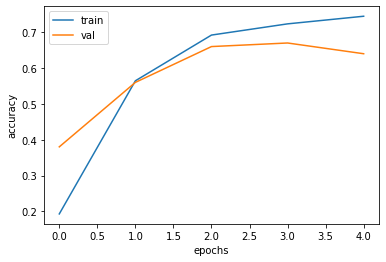

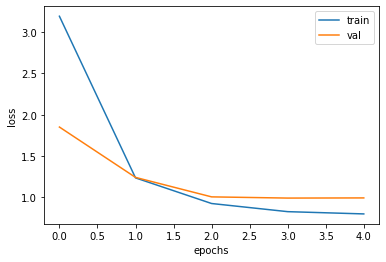

In [87]:
def plot_performance(metric, values):
  plt.plot(values['train'])
  plt.plot(values['val'])
  plt.xlabel("epochs")
  plt.ylabel(metric)
  plt.legend(values.keys())
  plt.show()

plot_performance('accuracy', accuracies)
plot_performance('loss', losses)

In [ ]:
torch.save(model.state_dict(),"weights.pth")

In [68]:
def test_model(model, criterion, optimizer, scheduler):

    model.eval()   # Set model to evaluate mode

    t_output = []
    t_pred = []
    y_test = []
    top_k = []
    # Iterate over data.
    i = 1
    for inputs, labels in dataloaders['test']:
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_test.append(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(True):
            outputs = model(inputs.float())
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            t_output.append(outputs)
            t_pred.append(preds)
            temp1, temp2 = outputs.topk(5)
            top_k.append(temp2)

    y_test = torch.cat(y_test).cpu().detach().numpy() 
    y_test_num = torch.cat(t_pred).cpu().detach().numpy() 
    y_pred = torch.cat(top_k).cpu().detach().numpy() 

    print('\nConfusion Matrix')
    conf_mt = confusion_matrix(y_test_num, y_test)
    print(conf_mt)
    plt.matshow(conf_mt)
    plt.show()
    print('\nClassification Report')
    print(classification_report(y_test_num, y_test, zero_division=0))

In [69]:
torch.cuda.empty_cache() 


Confusion Matrix
[[7 0 1 0 0 0 0 0 0 0]
 [0 7 1 0 0 0 0 0 0 0]
 [0 0 6 0 1 0 0 0 0 0]
 [0 0 0 6 0 2 3 1 0 1]
 [0 0 0 0 6 0 0 1 0 0]
 [0 0 0 1 0 8 1 0 1 0]
 [0 0 1 2 1 0 6 0 1 1]
 [2 0 1 0 1 0 0 7 1 0]
 [1 3 0 0 1 0 0 0 7 0]
 [0 0 0 1 0 0 0 1 0 8]]


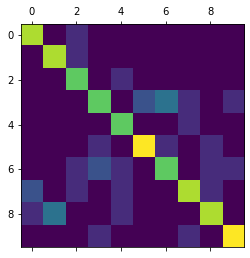


Classification Report
              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.70      0.88      0.78         8
           2       0.60      0.86      0.71         7
           3       0.60      0.46      0.52        13
           4       0.60      0.86      0.71         7
           5       0.80      0.73      0.76        11
           6       0.60      0.50      0.55        12
           7       0.70      0.58      0.64        12
           8       0.70      0.58      0.64        12
           9       0.80      0.80      0.80        10

    accuracy                           0.68       100
   macro avg       0.68      0.71      0.69       100
weighted avg       0.68      0.68      0.67       100



In [70]:
test_model(model, criterion, optimizer, exp_lr_scheduler)

In [89]:
print(torch.__version__)

1.10.0+cu111
